In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout
from tensorflow.keras.layers import concatenate

In [28]:
hidden_dim = 2
num_classes = 10 # число классов
batch_size = 100  # должно быть кратно 60 000 и 10 0000

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# стандартизация входных данных
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)


In [29]:
def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))

input_img = Input(shape=(28, 28, 1))
fl = Flatten()(input_img)
lb = Input(shape=(num_classes,)) # слой для метки класса
x = concatenate([fl, lb]) # для объединения 2х входов
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

z_mean2 = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

def noiser(args): # генерирует вектор начальной величины
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(z_log_var / 2) * N + z_mean

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean2, z_log_var])

In [30]:

input_dec = Input(shape=(hidden_dim,))
lb_dec = Input(shape=(num_classes,))
d = concatenate([input_dec, lb_dec])
d = Dense(128, activation='elu')(d)
d = dropout_and_batch(d)
d = Dense(256, activation='elu')(d)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)


In [31]:
encoder = keras.Model([input_img, lb], h, name='encoder')
decoder = keras.Model([input_dec, lb_dec], decoded, name='decoder')
cvae = keras.Model([input_img, lb, lb_dec], decoder([encoder([input_img, lb]), lb_dec]), name="cvae")

z_meaner = keras.Model([input_img, lb], z_mean2) 
# Создаем спец. слов: вход(изображение и метку класса, а на выходе только мат ожидание)
tr_style = keras.Model([input_img, lb, lb_dec], decoder([z_meaner([input_img, lb]), lb_dec]), name='tr_style')
# в декодере на вход верхнюю часть z_meaner
# -> это кодер и декодер, который исключает дисперсию
# tr_style - уже обученная сеть, но без дисперсии

def vae_loss(x, y): # x - входные, у - требуемые выходные
    x = K.reshape(x, shape=(batch_size, 28*28)) # преобрзовываем их в двумерные тензоры
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1) # сумма квадратов рассолгасований между входами и выходами (получается тензор (1 x batch_size)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # axis=-1 - вычисление по последней оси 
    return (loss + kl_loss)/2/28/28 # /2/28/28 - масштабирующий множитель


cvae.compile(optimizer='adam', loss=vae_loss)

In [32]:
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, epochs=5, batch_size=batch_size, shuffle=True)
#[x_train, y_train_cat, y_train_cat] - (обучающая выборка, вход метки для кодера, вход метки для декодера) 

Epoch 1/5
600/600 [==============================] - 4s 6ms/step - loss: 0.0393
Epoch 2/5
600/600 [==============================] - 3s 6ms/step - loss: 0.0240
Epoch 3/5
600/600 [==============================] - 5s 8ms/step - loss: 0.0233
Epoch 4/5
600/600 [==============================] - 4s 7ms/step - loss: 0.0230
Epoch 5/5
600/600 [==============================] - 4s 7ms/step - loss: 0.0227


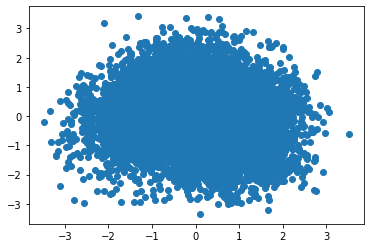

In [33]:
lb = lb_dec = y_test_cat
h = encoder.predict([x_test, lb], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])


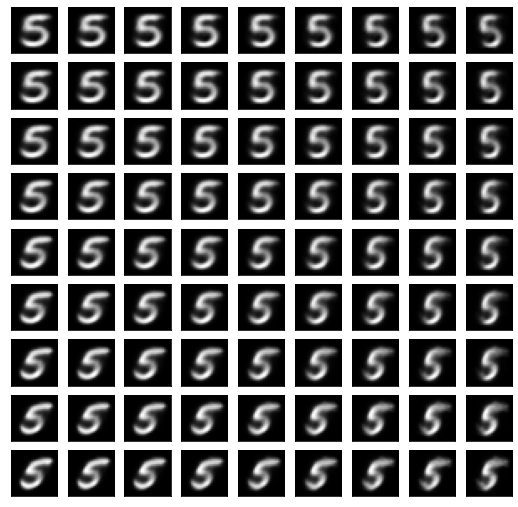

In [34]:
n = 4
total = 2*n+1
input_lbl = np.zeros((1, num_classes))
input_lbl[0, 5] = 1

plt.figure(figsize=(total, total))

h = np.zeros((1, hidden_dim))
num = 1
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num += 1
        h[0, :] = [1*i/n, 1*j/n]
        img = decoder.predict([h, input_lbl]) # input_lbl- метка класса
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

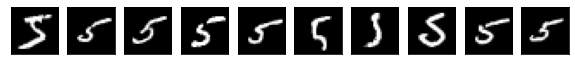

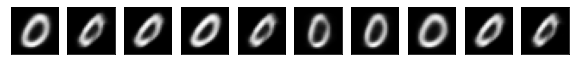

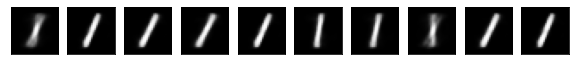

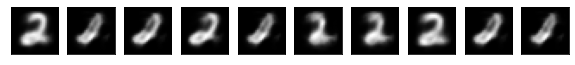

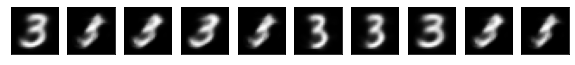

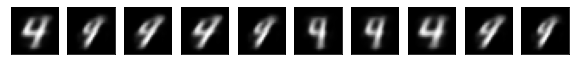

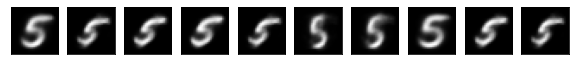

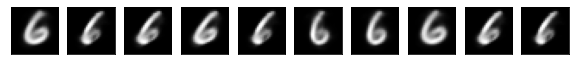

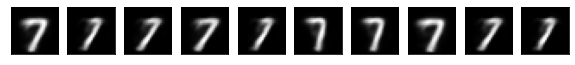

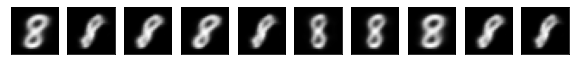

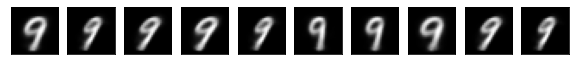

In [35]:

def plot_digits(*images): # отображает сгенерированное изображение в консоль
    images = [x.squeeze() for x in images]
    n = min([x.shape[0] for x in images])
    
    plt.figure(figsize=(n, len(images)))
    for j in range(n):
        for i in range(len(images)):
            ax = plt.subplot(len(images), n, i*n + j + 1)
            plt.imshow(images[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

dig1 = 5 # метка первого класса
dig2 = 2 # и второго

num = 10
X = x_train[y_train == dig1][:num] # выделяет 10 цифр из обучающей выборки, соотв-их 1му классу

lb_1 = np.zeros((num, num_classes))
lb_1[:, dig1] = 1

plot_digits(X)

for i in range(num_classes):
    lb_2 = np.zeros((num, num_classes))
    lb_2[:, i] = 1

    Y = tr_style.predict([X, lb_1, lb_2], batch_size=num)
    plot_digits(Y)